[IPython Notebook](rossiter_mclaughlin.ipynb) |  [Python Script](rossiter_mclaughlin.py)

Rossiter-McLaughlin Effect
============================

Setup
-----------------------------

In [1]:
%matplotlib inline

As always, let's do imports and initialize a logger and a new bundle.  See [Building a System](../tutorials/building_a_system.html) for more details.

In [2]:
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger(clevel='INFO')

b = phoebe.Bundle.default_binary()

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
/usr/local/lib/python2.7/dist-packages/astropy/units/quantity.py:732: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return super(Quantity, self).__eq__(other)


Let's make a significant mass ratio and radius ratio...

In [3]:
b['q'] = 0.7

In [4]:
b['rpole@primary'] = 1.0

In [5]:
b['rpole@secondary'] = 0.5

In [6]:
b['teff@secondary@component'] = 5000

Make sure the primary star is spinning quickly...

In [7]:
b['syncpar@primary@component'] = 2

Adding Datasets
-------------------

Now we'll add radial velocity and mesh datasets.  We'll add two identical datasets for RVs so that we can have one computed dynamically and the other computed numerically (these options will need to be set later).

In [8]:
b.add_dataset('RV', time=np.linspace(0,6,201), dataset='dynamicalrvs')  
# TODO: can't set rv_method here because compute options don't exist yet... and that's kind of annoying

<ParameterSet: 24 parameters | methods: RV, RV_dep>

In [9]:
b.add_dataset('RV', time=np.linspace(0,6,201), dataset='numericalrvs')

<ParameterSet: 24 parameters | methods: RV, RV_dep>

Storing the mesh at every timestep is overkill, and will be both computationally and memory intensive.  So let's just sample at the times we care about.

In [10]:
times = b.get_value('time@primary@numericalrvs@dataset')
times = times[times<0.2]
print times

[ 0.    0.03  0.06  0.09  0.12  0.15  0.18]


In [11]:
b.add_dataset('MESH', dataset='mesh01', time=times)

<ParameterSet: 1 parameters>

Running Compute
--------------------

In [12]:
b.add_compute(compute='mycompute')

<ParameterSet: 18 parameters | qualifiers: dynamics_method, gridsize, stepsize, lc_method, atm, enabled, ltte, rv_grav, orbiterror, rv_method, etv_method, maxpoints, delta, etv_tol, store_mesh, distortion_method, eclipse_alg, mesh_method>

Now let's set the rv_method so that one dataset uses the dynamical method and the other uses the flux-weighted (numerical) method.  Note that here we have to use set_value_all or loop over the components, as technically there are parameters for each component-dataset pair.

In [13]:
b.set_value_all('rv_method@dynamicalrvs@mycompute', 'dynamical')
b.set_value_all('rv_method@numericalrvs@mycompute', 'flux-weighted')

Let's check to make sure that rv_method is set as we'd expect.

In [14]:
print b['rv_method']

rv_method@_default@_default@mycompute@phoebe@compute: flux-weighted
rv_method@_default@numericalrvs@mycompute@compute: flux-weighted
rv_method@_default@dynamicalrvs@mycompute@compute: dynamical
rv_method@primary@numericalrvs@mycompute@compute: flux-weighted
rv_method@primary@dynamicalrvs@mycompute@compute: dynamical
rv_method@secondary@numericalrvs@mycompute@compute: flux-weighted
rv_method@secondary@dynamicalrvs@mycompute@compute: dynamical


In [15]:
b.run_compute()

<ParameterSet: 430 parameters | methods: RV, MESH>

Plotting 
---------------

Now let's plot the radial velocities.

First we'll plot the dynamical RVs.  Note that dynamical RVs show the true radial velocity of the center of mass of each star, and so we do not see the Rossiter McLaughlin effect.

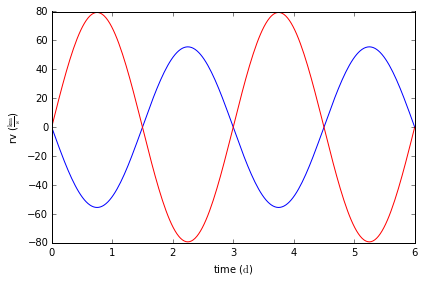

In [16]:
axs, artists = b['dynamicalrvs@model'].plot(component='primary', color='b')
axs, artists = b['dynamicalrvs@model'].plot(component='secondary', color='r')

But the numerical method integrates over the visible surface elements, giving us what we'd observe if deriving RVs from observed spectra of the binary.  Here we do see the Rossiter McLaughlin effect.  You'll also notice that RVs are not available for the secondary star when its completely occulted (they're nans in the array).

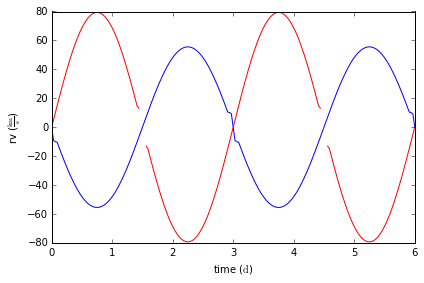

In [17]:
axs, artists = b['numericalrvs@model'].plot(component='primary', color='b')
axs, artists = b['numericalrvs@model'].plot(component='secondary', color='r')

To visualize what is happening, we can plot the radial velocities of each surface element in the mesh at one of these times.

Here just plot on the MESH@model parameterset - the mesh will automatically get coordinates from mesh01 and then we point to rv@numericalrvs for the facecolors.

/home/kyle/.local/lib/python2.7/site-packages/phoebe/frontend/plotting.py:240: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pckwargs['edgecolors'] in ['none', 'None', None] and pckwargs['facecolors'] not in ['none', 'None', None]:
/home/kyle/.local/lib/python2.7/site-packages/phoebe/frontend/plotting.py:240: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pckwargs['edgecolors'] in ['none', 'None', None] and pckwargs['facecolors'] not in ['none', 'None', None]:
/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


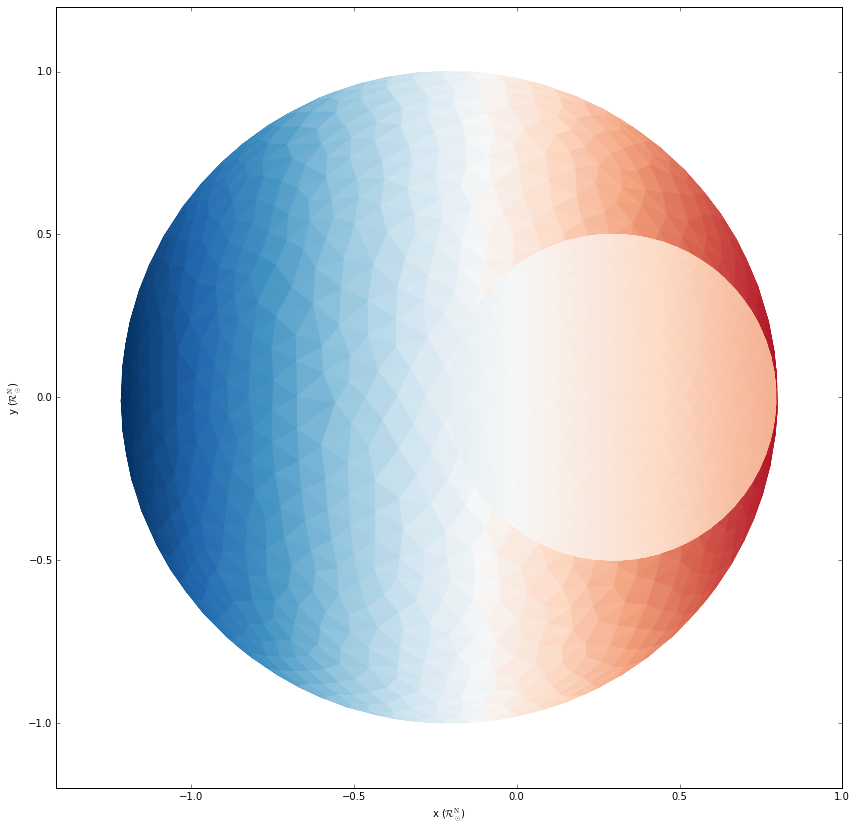

In [18]:
fig = plt.figure(figsize=(12,12))
axs, artists = b['MESH@model'].plot(time=0.03, facecolor='rv@numericalrvs', edgecolor=None)

Here you can see that the secondary star is blocking part of the "red" RVs of the primary star.

This is essentially the same as plotting the negative z-component of the velocities (for convention - our system is in a right handed system with +z towards the viewer, but RV convention has negative RVs for blue shifts).

We could also plot the RV per triangle by plotting 'vz'.  Note that this is actually defaulting to an inverted colormap to show you the same colorscheme ('RdBu_r' vs 'RdBu').

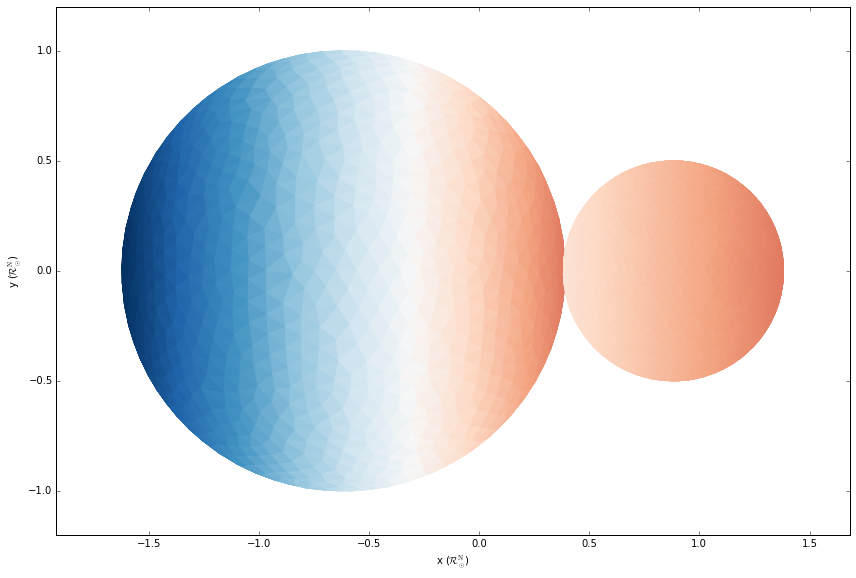

In [19]:
fig = plt.figure(figsize=(12,12))
axs, artists = b['mesh01@model'].plot(time=0.09, facecolor='vz', edgecolor=None)